### О ЛР:

- Coding Gradient boosting

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку (Она тут равняется 6).

**Оценка**:

***DeadLine - 28.05.2024 23:59***

### Формат сдачи
Задания сдаются через lms. Вы прикрепляете **ССЫЛКУ НА ПУБЛИЧНЫЙ РЕПОЗИТОРИЙ**, где выполнено ваше задание. Иначе задание не проверяется.

In [ ]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split


sns.set(style="darkgrid")
filterwarnings("ignore")

In [ ]:
x = load_npz("x.npz")
y = np.load("y.npy")

Разделим на обучающую, валидационную и тестовую выборки (`random_state` оставьте равным 666 для воспроизводимости).

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=666
)

x_test, x_valid, y_test, y_valid = train_test_split(
    x_test, y_test, test_size=0.5, random_state=666
)

x_train.shape, x_valid.shape, x_test.shape

((18825, 169), (2354, 169), (2353, 169))

## Задание 1. Реализация градиентного бустинга [2 балла]

Необходимо дописать код в файле `boosting.py`. Уже создан шаблон класса `Boosting`, который можно модифицировать по своему усмотрению.

### Описание функций:

#### `__init__`

Конструктор класса принимает следующие параметры:

- `base_model_class` — класс базовой модели для бустинга.
- `base_model_params` — словарь гиперпараметров для базовой модели.
- `n_estimators` — количество базовых моделей для обучения.
- `learning_rate` — темп обучения, должен быть в диапазоне (0, 1].
- `subsample` — доля обучающей выборки для тренировки базовой модели (размер бутстрап-выборки относительно исходной).
- `early_stopping_rounds` — число итераций без улучшения на валидационной выборке, после которых обучение прекращается.
- `plot` — флаг для построения графика качества моделей после обучения.

#### `fit`

Метод `fit` принимает обучающую и валидационную выборки.

1. Инициализируем нулевую модель и делаем предсказания (например, все нули) для обеих выборок.
2. Обучаем `n_estimators` базовых моделей:
   - Обучаем новую базовую модель на текущих остатках.
   - Обновляем предсказания на обучающей и валидационной выборках.
   - Рассчитываем ошибки на обеих выборках с помощью `loss_fn`.
   - Проверяем условия для ранней остановки.

3. Если флаг `plot` установлен, строим график качества после обучения всех моделей.

#### `fit_new_base_model`

Метод `fit_new_base_model` принимает обучающую выборку и текущие предсказания для неё.

1. Генерируем бутстрап-выборку.
2. Обучаем базовую модель на этой выборке.
3. Оптимизируем значение гаммы.
4. Добавляем новую базовую модель и гамму в соответствующие списки (учитывая `learning_rate`).

#### `predict_proba`

Метод `predict_proba` принимает выборку для предсказания вероятностей.

1. Суммируем предсказания базовых моделей (учитывая гамму и `learning_rate`).
2. Применяем сигмоидальную функцию для получения вероятностей.

In [ ]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%autoreload 2

from boosting import Boosting

### Проверка кода

У автора задания всё учится около одной секунды.

In [ ]:
boosting = Boosting()

% time boosting.fit(x_train, y_train, x_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(x_test).shape == (x_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}')

CPU times: user 924 ms, sys: 0 ns, total: 924 ms
Wall time: 924 ms
Train ROC-AUC 0.9921
Valid ROC-AUC 0.9172
Test ROC-AUC 0.9110


In [ ]:
boosting = Boosting()
def loss_fn(y_true, y_pred):
    # Например, можно использовать Mean Squared Error
    return ((y_true - y_pred) ** 2).mean()
%time boosting.fit(x_train, y_train, x_valid, y_valid, loss_fn)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(x_test).shape == (x_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}')

CPU times: user 2.19 s, sys: 1.41 ms, total: 2.2 s
Wall time: 2.25 s
Train ROC-AUC 0.9891
Valid ROC-AUC 0.9364
Test ROC-AUC 0.9442


## Задание 2. Обучение градиентного бустинга [0.5 балла]

Оцените качество вашей реализации градиентного бустинга на тестовой выборке, используя базовые модели — решающие деревья с различной максимальной глубиной. Метрикой будет ROC-AUC.

**Инструкция:**
1. Перебирайте значения максимальной глубины деревьев от 1 до 30 с шагом 2.
2. Оставьте остальные параметры бустинга по умолчанию.
3. Постройте график зависимости качества на обучающей и тестовой выборке от максимальной глубины деревьев.

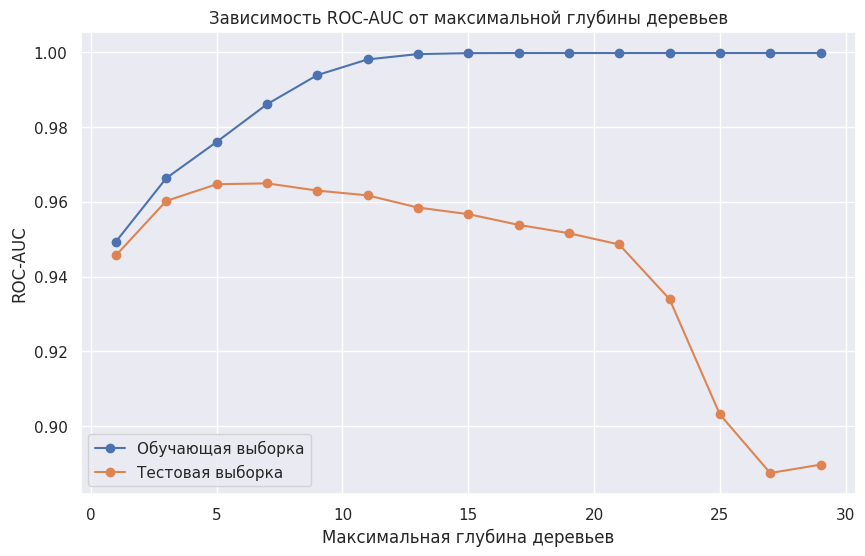

In [ ]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Допустим, X_train, X_test, y_train, y_test уже загружены и готовы к использованию.

train_results = []
test_results = []
max_depths = range(1, 31, 2)

for max_depth in max_depths:
    # Создаем и обучаем градиентный бустинг
    model = GradientBoostingClassifier(max_depth=max_depth)
    model.fit(x_train, y_train)

    # Предсказываем для обучающей выборки и вычисляем ROC-AUC
    train_pred = model.predict_proba(x_train)[:, 1]
    train_auc = roc_auc_score(y_train, train_pred)
    train_results.append(train_auc)

    # Предсказываем для тестовой выборки и вычисляем ROC-AUC
    test_pred = model.predict_proba(x_test)[:, 1]
    test_auc = roc_auc_score(y_test, test_pred)
    test_results.append(test_auc)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_results, label='Обучающая выборка', marker='o')
plt.plot(max_depths, test_results, label='Тестовая выборка', marker='o')
plt.xlabel('Максимальная глубина деревьев')
plt.ylabel('ROC-AUC')
plt.title('Зависимость ROC-AUC от максимальной глубины деревьев')
plt.legend()
plt.show()

**Какая из моделей имеет лучшее качество? Как вы можете это объяснить?**

Дерево глубиной 7 имеет лучшее качество, так как деревья меньшей глубины "задают меньше вопросов к данным", что ведёт к меньшей точности. При дальнейшем же увеличении глубины дерева возникает проблема переобучения.

## Задание 3. Подбор гиперпараметров и поиск оптимальной модели [3 балла]

Настройте основные гиперпараметры вашей модели градиентного бустинга, используя валидационную выборку. Подберите параметры как для самого бустинга, так и для базовых моделей.

**Рекомендации:**
- Используйте библиотеки для автоматизированного подбора гиперпараметров, такие как [Hyperopt](https://github.com/hyperopt/hyperopt) или [Optuna](https://optuna.org/).
- Подберите все основные параметры, чтобы найти лучшую модель на валидационной выборке.

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 9.1 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier


def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 100),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    }

    model = GradientBoostingClassifier(**param)

    scores = cross_val_score(model, x_train, y_train, n_jobs=-1, cv=3,
                             scoring='roc_auc')

    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
print(best_params)

[I 2024-05-10 17:00:13,207] A new study created in memory with name: no-name-5d32261b-2885-48e5-9203-c4b3eba3952b
[I 2024-05-10 17:00:39,070] Trial 0 finished with value: 0.9608924151170036 and parameters: {'n_estimators': 238, 'max_depth': 4, 'min_samples_split': 89, 'min_samples_leaf': 55, 'learning_rate': 0.02836755985454116, 'subsample': 0.9155913204430601, 'max_features': 'auto'}. Best is trial 0 with value: 0.9608924151170036.
[I 2024-05-10 17:00:46,006] Trial 1 finished with value: 0.9637980545249415 and parameters: {'n_estimators': 147, 'max_depth': 6, 'min_samples_split': 96, 'min_samples_leaf': 98, 'learning_rate': 0.25037792657754926, 'subsample': 0.7648062763450088, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9637980545249415.
[I 2024-05-10 17:00:50,332] Trial 2 finished with value: 0.9484504865558655 and parameters: {'n_estimators': 56, 'max_depth': 10, 'min_samples_split': 14, 'min_samples_leaf': 40, 'learning_rate': 0.02481134654638516, 'subsample': 0.84478169

{'n_estimators': 272, 'max_depth': 9, 'min_samples_split': 78, 'min_samples_leaf': 4, 'learning_rate': 0.04686993243472524, 'subsample': 0.7006901551163515, 'max_features': 'sqrt'}


In [ ]:
model = GradientBoostingClassifier(**best_params)
model.fit(x_train, y_train)
val_pred = model.predict_proba(x_valid)[:, 1]
val_auc = roc_auc_score(y_valid, val_pred)
print(f'ROC-AUC на валидационной выборке: {val_auc}')

ROC-AUC на валидационной выборке: 0.9677575313895275


## Задание 4. Интерпретация градиентного бустинга [1 балл]

Постройте калибровочную кривую для вашей лучшей модели градиентного бустинга и оцените, насколько точно модель предсказывает вероятности.

**Инструкция:**
1. Постройте калибровочную кривую для лучшей модели градиентного бустинга.
2. Постройте аналогичную кривую для логистической регрессии.
3. Сравните полученные результаты и проанализируйте, насколько хорошо каждая модель оценивает вероятности.

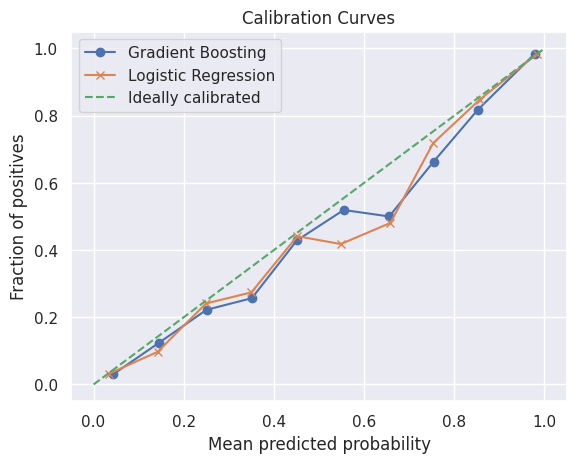

In [ ]:
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

gb_model = GradientBoostingClassifier(**best_params)
lr_model = LogisticRegression(max_iter=1000)

gb_model.fit(x_train, y_train)
lr_model.fit(x_train, y_train)

gb_probs = gb_model.predict_proba(x_valid)[:, 1]
lr_probs = lr_model.predict_proba(x_valid)[:, 1]

gb_reliability, gb_bins = calibration_curve(y_valid, gb_probs, n_bins=10)
lr_reliability, lr_bins = calibration_curve(y_valid, lr_probs, n_bins=10)

plt.plot(gb_bins, gb_reliability, marker='o', label='Gradient Boosting')
plt.plot(lr_bins, lr_reliability, marker='x', label='Logistic Regression')

plt.plot([0, 1], [0, 1], linestyle='--', label='Ideally calibrated')

plt.title('Calibration Curves')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.legend()
plt.grid(True)
plt.show()

Теперь оценим важность признаков для градиентного бустинга.

**Задание:**
1. Поскольку базовая модель — дерево из `sklearn`, вычислите важность каждого признака для каждого дерева, используя атрибут `feature_importances_` у `DecisionTreeRegressor`.
2. Усредните значения важности по всем деревьям и нормализуйте их так, чтобы сумма была равна единице (убедитесь, что значения неотрицательны).
3. Дополните вашу реализацию бустинга, добавив метод `feature_importances_`, который будет возвращать усредненные и нормализованные важности признаков.

**Построение графиков:**
1. Постройте столбчатую диаграмму важности признаков для градиентного бустинга.
2. На соседнем графике изобразите важность признаков для логистической регрессии, используя модули весов.
3. Сравните графики и проанализируйте полученные результаты.

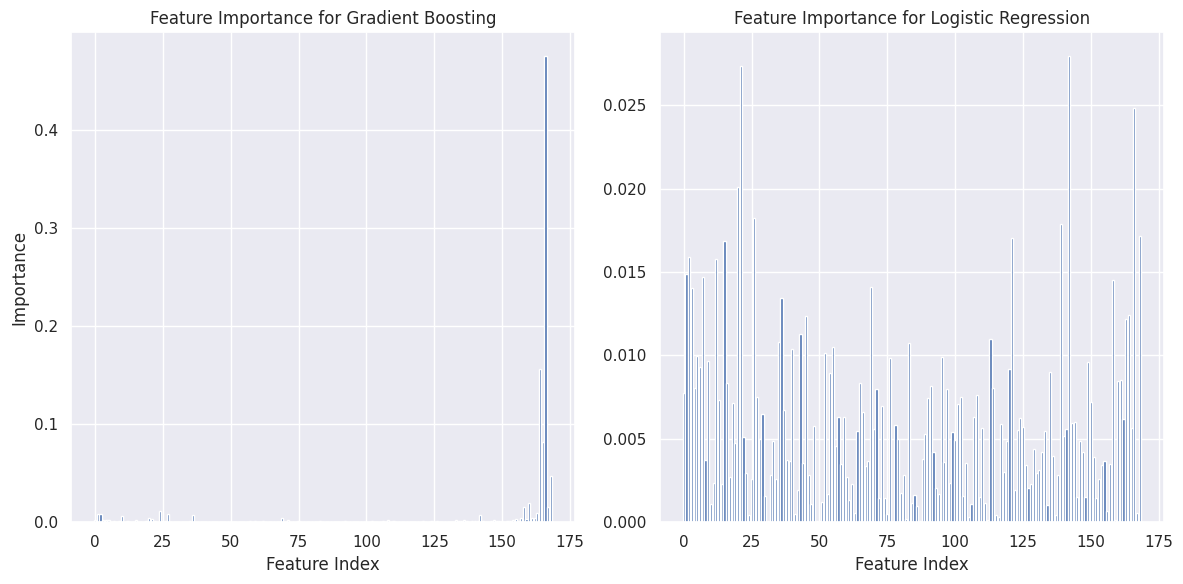

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(range(len(gb_model.feature_importances_)), gb_model.feature_importances_)
plt.title('Feature Importance for Gradient Boosting')
plt.xlabel('Feature Index')
plt.ylabel('Importance')

plt.subplot(1, 2, 2)
lr_importance = np.abs(lr_model.coef_[0])
lr_importance /= lr_importance.sum()
plt.bar(range(len(lr_importance)), lr_importance)
plt.title('Feature Importance for Logistic Regression')
plt.xlabel('Feature Index')

plt.tight_layout()
plt.show()

Обычно избыточные признаки могут негативно влиять на качество бустинга. Попробуйте следующее:

1. **Отфильтруйте неважные признаки:** Используйте построенную диаграмму важности признаков, чтобы отобрать наиболее незначительные признаки.
2. **Обучите модель повторно:** Обучите модель на основе оставшихся признаков с теми же гиперпараметрами.
3. **Оцените качество модели:** Сравните результаты новой модели с исходной. Улучшилось ли качество после отфильтровывания незначительных признаков?

In [ ]:
threshold = np.percentile(gb_model.feature_importances_, 25)
important_features = np.where(gb_model.feature_importances_ > threshold)[0]

X_train_filtered = x_train[:, important_features]
X_test_filtered = x_test[:, important_features]

gb_model.fit(X_train_filtered, y_train)

y_pred_filtered = gb_model.predict(X_test_filtered)
accuracy_filtered = accuracy_score(y_test, y_pred_filtered)

print(f"Original Accuracy: {val_auc:.2f}")
print(f"Filtered Model Accuracy: {accuracy_filtered:.2f}")

Original Accuracy: 0.97
Filtered Model Accuracy: 0.68


## Задание 5 (бонус). Блендинговое [0.5 балла]

Реализуйте блендинг над вашей лучшей моделью и логистической регрессией. Улучшилось ли качество?

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
gb_model = GradientBoostingClassifier(**best_params)
lr_model = LogisticRegression(max_iter=1000)

gb_model.fit(x_train, y_train)
lr_model.fit(x_train, y_train)

gb_pred = gb_model.predict_proba(x_test)[:, 1]
lr_pred = lr_model.predict_proba(x_test)[:, 1]

blended_pred = (gb_pred + lr_pred) / 2
blended_pred_class = np.round(blended_pred).astype(int)
blended_accuracy = accuracy_score(y_test, blended_pred_class)

gb_accuracy = accuracy_score(y_test, gb_model.predict(x_test))
lr_accuracy = accuracy_score(y_test, lr_model.predict(x_test))

print(f"Gradient Boosting Accuracy: {gb_accuracy:.2f}")
print(f"Logistic Regression Accuracy: {lr_accuracy:.2f}")
print(f"Blended Model Accuracy: {blended_accuracy:.2f}")

if blended_accuracy > max(gb_accuracy, lr_accuracy):
    print("Ура! Блендинг действительно улучшил нашу модель! 🎉✨")
else:
    print("Ой-ой... Похоже, блендинг на этот раз не помог. Надо попробовать что-то еще. 🤔") #смайлики

Gradient Boosting Accuracy: 0.91
Logistic Regression Accuracy: 0.90
Blended Model Accuracy: 0.60
Ой-ой... Похоже, блендинг на этот раз не помог. Надо попробовать что-то еще. 🤔


## Задание 6 (бонус). Катбустовое [0.5 балла]

Запустите [CatBoost](https://catboost.ai/en/docs/concepts/python-quickstart) на наших данных, сравните с вашей реализацией. Где получилось лучше?

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.3 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

cb_model = CatBoostClassifier()
cb_model.fit(x_train, y_train, verbose=False)

cb_pred = cb_model.predict(x_test)
cb_accuracy = accuracy_score(y_test, cb_pred)

print(f"CatBoost Accuracy: {cb_accuracy:.2f}")

CatBoost Accuracy: 0.91


Оставьте пожалуйста отзыв о курсе!

https://forms.gle/LajA3Xrps6u96Q5A8


Это очень важно. Благодаря обратной связи мы будем двигаться в сторону антиградиента)
